# 2016 MC cross-section corrections

In [63]:
%cd '/home/naodell/work/CMS/amumu'
%matplotlib notebook

from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import nllfitter.plot_tools as pt

/home/naodell/work/CMS/amumu


Carry out some initial configuration.

In [64]:
ntuple_dir  = 'data/flatuples/mumu_2016'
lumi        = 36.4e3
selection   = ('mumu', 'combined')
period      = 2016
output_path = 'plots/fits/{0}_{1}'.format('_'.join(selection), period)

The predominant samples are ttbar and Drell-Yan.  The Drell-Yan sample should be split into $10 < M < 50$ and $M > 50$.  If it makes sense, I will also apply corrections based on jet multiplicity.

In [65]:
datasets    = [
               'muon_2016B', 'muon_2016C', 'muon_2016D',
               'muon_2016E', 'muon_2016F', 'muon_2016G', 'muon_2016H',

               'ttbar_lep',                      
               'zjets_m-50',  'zjets_m-10to50',  
               'z1jets_m-50', 'z1jets_m-10to50', 
               'z2jets_m-50', 'z2jets_m-10to50', 
               'z3jets_m-50', 'z3jets_m-10to50', 
               'z4jets_m-50', 'z4jets_m-10to50', 
              ]
features = [
            'lepton1_pt', 'lepton2_pt', 
            'lepton_delta_eta', 'lepton_delta_phi', 'lepton_delta_r',
            'dilepton_mass', 'dilepton_pt', 'dilepton_eta',
            'n_jets', 'n_fwdjets', 'n_bjets', 
            #'bjet_pt', 'bjet_eta', 'bjet_phi', 'bjet_d0',
            #'jet_pt', 'jet_eta', 'jet_phi', 'jet_d0', 
            #'dijet_mass', 'dijet_pt', 'dijet_eta', 'dijet_phi', 
            #'dijet_pt_over_m',
           ]

cuts     = 'lepton1_pt > 25 and abs(lepton1_eta) < 2.1 \
            and lepton2_pt > 25 and abs(lepton2_eta) < 2.1 \
            and lepton1_q != lepton2_q and 12 < dilepton_mass < 70 \
            and n_bjets > 0'

dm = pt.DataManager(input_dir     = ntuple_dir,
                    dataset_names = datasets,
                    selection     = selection[0],
                    period        = period,
                    scale         = lumi,
                    cuts          = cuts
                    )


Loading dataframes: 100%|███████████████| 18.0/18.0 [00:08<00:00, 2.29it/s]


First thing will be to get a list of histograms.

<IPython.core.display.Javascript object>


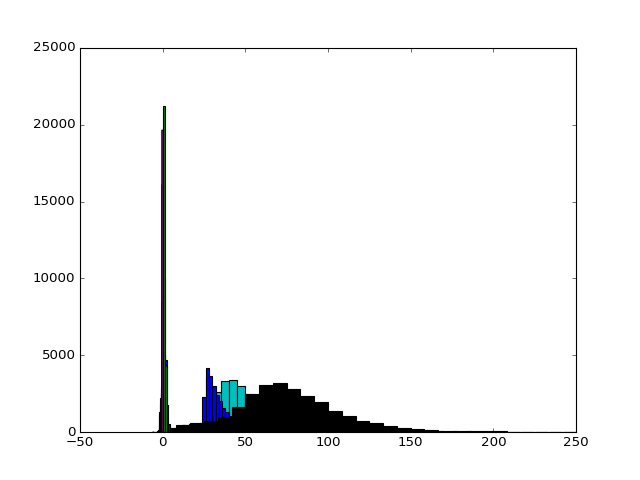

In [66]:
labels = ['ttbar', 'zjets_lm', 'zjets_hm']

mc_hists = {}
data_hists = {}
for feature in tqdm_notebook(features):
    hist_lut = dm._lut_features.loc[feature]
    
    ### Get MC histograms
    data, weights = pt.get_data_and_weights(dm.get_dataframes(labels), feature, labels)
    h, b, _ = plt.hist(data, 
                       bins = hist_lut.n_bins, 
                       range = (hist_lut.xmin, hist_lut.xmax), 
                       weights=weights
                      )
    mc_hists[feature] = (h,b)
    
    ### Get data histograms
    data, weights = pt.get_data_and_weights(dm.get_dataframes(['data']), feature, ['data'])
    h, b, _ = plt.hist(data, 
                       bins = hist_lut.n_bins, 
                       range = (hist_lut.xmin, hist_lut.xmax), 
                       weights=weights
                      )
    data_hists[feature] = (h,b)

Now we have all of our data.  Let's construct the objective function.

In [71]:
def objective(params, target, templates, features):
    chi2 = []
    for feature in features:
        temps = np.array(templates[feature][0])
        x = np.dot(temps.transpose(), params)
        y = target[feature][0]
        
        x, y = x[y>0], y[y>0]
        quad_err = np.sum((y - x)**2/y)
        chi2.append(quad_err)
    
    return np.mean(chi2) + 1000*np.abs(np.sum(params)/3 - 1)

Let's see if this works...

In [72]:
 result = minimize(objective,                              
                   len(labels)*[1.,],                                  
                   method = 'SLSQP',                       
                   #bounds = None,            
                   #constraints = None, 
                   args   = (data_hists, mc_hists, features)                               
                  ) 
result.x

array([ 1.00088746,  1.01432265,  0.98478959])